# Call Azure ML for PY Framework web service - tax withholding verification

###  http://b03d85f2-b070-497e-a0f8-03ec2315c0af.westus.azurecontainer.io/score
### - Predict Tax amounts per employee
### - Compare with actual tax amounts
### - Highlight discrepancies

### Imports

In [46]:
import json
import requests
from ngamlfpy.utils import pulled_json_to_df, pulled_df_to_json
from ngamlfpy.hrxmlconfig import MLModelConfig
from ngamlfpy.pipeline import FileFinder
import matplotlib.pyplot as plt
import pandas as pd
import os

ml_service = 'TWV'



In [47]:
use_csv_input = True
model_code =  'T001' #'SS01'
model_version = '002' #'010'
#input_file_name =  'TWV_SS01_010_EUH_SOL_SUS_BIWK_PP9_100_U3_201915_input.csv'
input_file_name= 'TWV_T001_002_EUH_ZCS_Z10_MTHLY_EQ1_402_X1_201902_input.csv'

finder = FileFinder(ml_service, use_model_name_in=True, use_model_name_out=False, model_name=model_code, model_version = model_version,
                         base_folder='./data', relative_input_folder=FileFinder.MLFOLDER_INPUT,
                         relative_output_folder=FileFinder.MLFOLDER_PREDICT)

full_path_in =  finder.get_full_input_file_name(input_file_name)  #os.path.join(args.data_folder, args.ml_service + '/input/' + args.model + '/' + args.model_version)

#full_path_in = os.path.join(folder,args.input_file_name)


df = pd.read_csv(full_path_in)
#df = pd.read_csv('data/PAD/input/' + model_code + '/PAD_EUH_AKN_A05_ALL_EP5_984_N0_201908_input.csv')
#df = pd.read_csv('data/PAD/input/M005/001/PAD_M005_001_EUH_ZZZ_Z10_MTHLY_EDF_310_ZZ_201905_input.csv')
display(df.head())

_,_,_,payroll_service, gcc, lcc, group, system, rest = finder.parse_input_file_name(input_file_name,include_remainder=True)
client, abkrs, period, other = rest.split('_')
ml_config = MLModelConfig.get_model_config_from_web_service_for_cust(ml_service, system=system,gcc=gcc,lcc=lcc,payroll_area=abkrs)


,MLService,Model,Version,GCC,LCC,Period,PayrollService,System,Client,ABKRS,...,EmpGroup,EmpSubgroup,ForPeriod,TaxableGross,Year,FilingStatus,TaxExIndicator,ExtraTaxAmount,NumExemptions,FedTaxWithholding
0,TWV,T001,2,ZCS,Z10,201902,EUH,EQ1,402,X1,...,1,80,201902,8353.34,2019,1,NaN,0,0,1438.54
1,TWV,T001,2,ZCS,Z10,201902,EUH,EQ1,402,X1,...,1,80,201902,7500.00,2019,1,NaN,0,0,1238.54
2,TWV,T001,2,ZCS,Z10,201902,EUH,EQ1,402,X1,...,1,80,201902,1666.66,2019,1,NaN,0,0,145.83
3,TWV,T001,2,ZCS,Z10,201902,EUH,EQ1,402,X1,...,1,80,201902,4166.66,2019,1,NaN,0,0,501.87
4,TWV,T001,2,ZCS,Z10,201902,EUH,EQ1,402,X1,...,1,80,201902,1666.66,2019,1,NaN,0,0,145.83


web service call successful:  api/model-info ?ml_service=TWV&system=EQ1&gcc=ZCS&lcc=Z10&payroll_area=X1


In [49]:
save_csv_file_as_json = True

if use_csv_input:
    print('Using csv input')
    #j_predict = pulled_df_to_json(df,ml_config,'201902')
    j_predict = pulled_df_to_json(df,ml_config,period,use_first_data_line_as_selection=True,use_value_title_format=True)

    raw_data = {}
    raw_data['data'] = j_predict

    if save_csv_file_as_json:
       predict_json_file_name =  input_file_name.split('.')[0] + '.json'
       full_path_json = os.path.join(finder.get_output_folder(),predict_json_file_name)
       print('Writing json predict in file: ', full_path_json)
       with open(full_path_json, 'w') as outfile:
           json.dump(raw_data, outfile, indent=4)
           
            
else:        
    import pprint
    input_json_file_name = '' # <-- supply json file name here (including path)
    print ('Using Json predict file: ',input_json_file_name)

    with open(input_json_file_name) as json_data:
            j_predict = json.load(json_data)

print('Num emps: ',len(j_predict['values']))
print('')
print('First emp: ',j_predict['values'][0])
print('')
print('Selection: ',j_predict['selection'])
print('')     

Using csv input
Writing json predict in file:  ./data\TWV\predict\TWV_T001_002_EUH_ZCS_Z10_MTHLY_EQ1_402_X1_201902_input.json
Num emps:  841

First emp:  [{'title': 'MLService', 'value': 'TWV'}, {'title': 'Model', 'value': 'T001'}, {'title': 'Version', 'value': 2}, {'title': 'GCC', 'value': 'ZCS'}, {'title': 'LCC', 'value': 'Z10'}, {'title': 'Period', 'value': 201902}, {'title': 'PayrollService', 'value': 'EUH'}, {'title': 'System', 'value': 'EQ1'}, {'title': 'Client', 'value': 402}, {'title': 'ABKRS', 'value': 'X1'}, {'title': 'PERNR', 'value': 99991082}, {'title': 'PersArea', 'value': 'ZUS1'}, {'title': 'EmpGroup', 'value': 1}, {'title': 'EmpSubgroup', 'value': 80}, {'title': 'ForPeriod', 'value': 201902}, {'title': 'TaxableGross', 'value': 8353.34}, {'title': 'Year', 'value': 2019}, {'title': 'FilingStatus', 'value': 1}, {'title': 'TaxExIndicator', 'value': nan}, {'title': 'ExtraTaxAmount', 'value': 0}, {'title': 'NumExemptions', 'value': 0}, {'title': 'FedTaxWithholding', 'value': 

## Prepare headers

In [50]:
headers = {"Content-Type":"application/json"}
test_samples = json.dumps({'data':j_predict})
test_samples = bytes(test_samples, encoding='utf8')        
        
print (json.dumps(j_predict['selection'], sort_keys=False, indent=4, separators=(',', ': ')))

[
    {
        "title": "MLService",
        "value": "TWV"
    },
    {
        "title": "Model",
        "value": "T001"
    },
    {
        "title": "Version",
        "value": 2
    },
    {
        "title": "GCC",
        "value": "ZCS"
    },
    {
        "title": "LCC",
        "value": "Z10"
    },
    {
        "title": "Period",
        "value": 201902
    },
    {
        "title": "PayrollService",
        "value": "EUH"
    },
    {
        "title": "System",
        "value": "EQ1"
    },
    {
        "title": "Client",
        "value": 402
    },
    {
        "title": "ABKRS",
        "value": "X1"
    }
]


# Call Prediction Web Service

### New  http://b03d85f2-b070-497e-a0f8-03ec2315c0af.westus.azurecontainer.io/score

- Predict Tax amounts per emp

In [51]:
test_samples[:200]

b'{"data": {"selection": [{"title": "MLService", "value": "TWV"}, {"title": "Model", "value": "T001"}, {"title": "Version", "value": 2}, {"title": "GCC", "value": "ZCS"}, {"title": "LCC", "value": "Z10"'

In [52]:
response = requests.post("http://b03d85f2-b070-497e-a0f8-03ec2315c0af.westus.azurecontainer.io/score", test_samples, headers=headers)  #NGA_Tax_Withheld  Combined


if response.status_code == 200:
    json_predictions = response.json()
    print('Prediction Web Service call successful - ' + str(len(json_predictions['Predictions'])) + ' emps processed' + ' Model used: ' + json_predictions['info']['model_code'] + ' Model config ws status: ' + json_predictions['info']['config_web_service_call_status'])

    print ('First 5 Tax predictions: ')
    for pred in json_predictions['Predictions'][:5]:
        print('   Predicted tax: ' + str(pred))
else:
    print('web service failed. Status: ' + str(response.status_code) + ' message: ' +  str(response.text))
    
acts = []
preds = []
for emp in json_predictions['Predictions']:
    preds.append(emp['Pred'])
    acts.append(emp['Actual'])    
    
 

Prediction Web Service call successful - 841 emps processed Model used: T001 Model config ws status: Success
First 5 Tax predictions: 
   Predicted tax: {'PERNR': '99991082', 'Pred': 1439.46, 'Actual': 1438.54}
   Predicted tax: {'PERNR': '99991084', 'Pred': 1237.5, 'Actual': 1238.54}
   Predicted tax: {'PERNR': '99991105', 'Pred': 145.61, 'Actual': 145.83}
   Predicted tax: {'PERNR': '99991107', 'Pred': 500.66, 'Actual': 501.87}
   Predicted tax: {'PERNR': '99991108', 'Pred': 145.61, 'Actual': 145.83}


In [53]:
json_predictions

{'selection': [{'title': 'MLService', 'value': 'TWV'},
  {'title': 'Model', 'value': 'T001'},
  {'title': 'Version', 'value': 2},
  {'title': 'GCC', 'value': 'ZCS'},
  {'title': 'LCC', 'value': 'Z10'},
  {'title': 'Period', 'value': 201902},
  {'title': 'PayrollService', 'value': 'EUH'},
  {'title': 'System', 'value': 'EQ1'},
  {'title': 'Client', 'value': 402},
  {'title': 'ABKRS', 'value': 'X1'}],
 'info': {'config_web_service_call_status': 'Success',
  'azure_model_name': 'TWV_model_T001_002',
  'model_code': 'T001',
  'model_version': '002',
  'pipeline_code_version': '0.1g',
  'predict_code_version': '0.1h'},
 'Predictions': [{'PERNR': '99991082', 'Pred': 1439.46, 'Actual': 1438.54},
  {'PERNR': '99991084', 'Pred': 1237.5, 'Actual': 1238.54},
  {'PERNR': '99991105', 'Pred': 145.61, 'Actual': 145.83},
  {'PERNR': '99991107', 'Pred': 500.66, 'Actual': 501.87},
  {'PERNR': '99991108', 'Pred': 145.61, 'Actual': 145.83},
  {'PERNR': '99991109', 'Pred': 500.66, 'Actual': 501.87},
  {'PE

# Compare Predictions with Actual

In [54]:
df_in = pulled_json_to_df(j_predict,use_value_title_format=True)
print(df_in.shape)
print(len(preds))

print(df_in.columns)     
df_in['Predicted Tax'] = preds #json_predictions['Predictions']
df_in = df_in.rename(columns={'FedTaxWithholding':'Actual Tax'})
df_in = df_in.drop(['GCC','LCC','PayrollService','System','ABKRS','Client','Period'],axis=1)
df_in['$ Diff'] = df_in['Predicted Tax'] - df_in['Actual Tax']
df_in['% Diff'] = df_in['$ Diff'] / df_in['Actual Tax'] * 100.0
df_in = df_in.round({'% Diff': 2})

df_in.head()

(841, 22)
841
Index(['MLService', 'Model', 'Version', 'GCC', 'LCC', 'Period',
       'PayrollService', 'System', 'Client', 'ABKRS', 'PERNR', 'PersArea',
       'EmpGroup', 'EmpSubgroup', 'ForPeriod', 'TaxableGross', 'Year',
       'FilingStatus', 'TaxExIndicator', 'ExtraTaxAmount', 'NumExemptions',
       'FedTaxWithholding'],
      dtype='object')


,MLService,Model,Version,PERNR,PersArea,EmpGroup,EmpSubgroup,ForPeriod,TaxableGross,Year,FilingStatus,TaxExIndicator,ExtraTaxAmount,NumExemptions,Actual Tax,Predicted Tax,$ Diff,% Diff
0,TWV,T001,2,99991082,ZUS1,1,80,201902,8353.34,2019,1,NaN,0,0,1438.54,1439.46,0.92,0.06
1,TWV,T001,2,99991084,ZUS1,1,80,201902,7500.00,2019,1,NaN,0,0,1238.54,1237.50,-1.04,-0.08
2,TWV,T001,2,99991105,ZUS1,1,80,201902,1666.66,2019,1,NaN,0,0,145.83,145.61,-0.22,-0.15
3,TWV,T001,2,99991107,ZUS1,1,80,201902,4166.66,2019,1,NaN,0,0,501.87,500.66,-1.21,-0.24
4,TWV,T001,2,99991108,ZUS1,1,80,201902,1666.66,2019,1,NaN,0,0,145.83,145.61,-0.22,-0.15


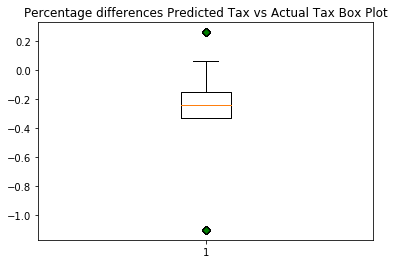

In [55]:
green_diamond = dict(markerfacecolor='g', marker='D')
data = df_in['% Diff']
fig1, ax1 = plt.subplots()
ax1.set_title('Percentage differences Predicted Tax vs Actual Tax Box Plot')
ax1.boxplot(data, flierprops=green_diamond)
plt.show()


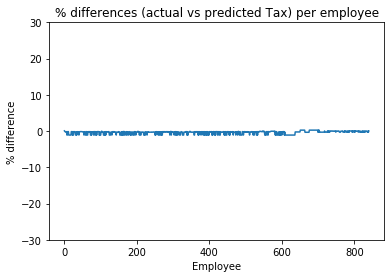

In [56]:
plt.title('% differences (actual vs predicted Tax) per employee')
plt.ylim(top=30,bottom=-30)
plt.ylabel('% difference')
plt.xlabel('Employee')
plt.plot(data) 
#run.log_image("Train set - Percentage diff per employee", plot=plt)
plt.show()

### Add "unusual" employee

In [60]:

unusual_data = [
                {
                    "title": "MLService",
                    "value": "TWV"
                },
                {
                    "title": "Model",
                    "value": "T001"
                },
                {
                    "title": "Version",
                    "value": 2
                },
                {
                    "title": "GCC",
                    "value": "ZCS"
                },
                {
                    "title": "LCC",
                    "value": "Z10"
                },
                {
                    "title": "Period",
                    "value": 201902
                },
                {
                    "title": "PayrollService",
                    "value": "EUH"
                },
                {
                    "title": "System",
                    "value": "EQ1"
                },
                {
                    "title": "Client",
                    "value": 402
                },
                {
                    "title": "ABKRS",
                    "value": "X1"
                },
                {
                    "title": "PERNR",
                    "value": 99991234
                },
                {
                    "title": "PersArea",
                    "value": "ZUS1"
                },
                {
                    "title": "EmpGroup",
                    "value": 1
                },
                {
                    "title": "EmpSubgroup",
                    "value": 80
                },
                {
                    "title": "ForPeriod",
                    "value": 201902
                },
                {
                    "title": "TaxableGross",
                    "value": 4266.00 #4166.00
                },
                {
                    "title": "Year",
                    "value": 2019
                },
                {
                    "title": "FilingStatus",
                    "value": 1
                },
                {
                    "title": "TaxExIndicator",
                    "value": ''
                },
                {
                    "title": "ExtraTaxAmount",
                    "value": 0
                },
                {
                    "title": "NumExemptions",
                    "value": 0
                },
                {
                    "title": "FedTaxWithholding",
                    "value": 501.87
                }

]



# unusual_data = {
          
#             "MLService": "TWV",
#             "Model":"T001",
#             "Version":1,
#             "GCC": "ZZZ",
#             "LCC": "Z10",
#             "Variant": "MTHLY",
#             "Period": 201902,
#             "PayrollService": "EUH",
#             "System": "EDF",
#             "Client": 310,
#             "ABKRS": "X1",
#             "PERNR": 1,
#             "PersArea": "ZUS1",
#             "EmpGroup": 1,
#             "EmpSubgroup": 80,
#             "ForPeriod": 201902,
#             "TaxableGross": 4266.66, # 4166.66
#             "Year": 2019,
#             "FilingStatus": 1,
#             "TaxExIndicator": 0,
#             "ExtraTaxAmount":0,
#             "NumExemptions": 0,
#             "ExemptInd": "R",
#             "FedTaxWithholding": 501.87
#        }

# }


j_predict['values'].append(unusual_data)
test_samples = json.dumps({'data':j_predict})
test_samples = bytes(test_samples, encoding='utf8') 


In [63]:
j_predict['values'][-1]

[{'title': 'MLService', 'value': 'TWV'},
 {'title': 'Model', 'value': 'T001'},
 {'title': 'Version', 'value': 2},
 {'title': 'GCC', 'value': 'ZCS'},
 {'title': 'LCC', 'value': 'Z10'},
 {'title': 'Period', 'value': 201902},
 {'title': 'PayrollService', 'value': 'EUH'},
 {'title': 'System', 'value': 'EQ1'},
 {'title': 'Client', 'value': 402},
 {'title': 'ABKRS', 'value': 'X1'},
 {'title': 'PERNR', 'value': 99991234},
 {'title': 'PersArea', 'value': 'ZUS1'},
 {'title': 'EmpGroup', 'value': 1},
 {'title': 'EmpSubgroup', 'value': 80},
 {'title': 'ForPeriod', 'value': 201902},
 {'title': 'TaxableGross', 'value': 4266.0},
 {'title': 'Year', 'value': 2019},
 {'title': 'FilingStatus', 'value': 1},
 {'title': 'TaxExIndicator', 'value': ''},
 {'title': 'ExtraTaxAmount', 'value': 0},
 {'title': 'NumExemptions', 'value': 0},
 {'title': 'FedTaxWithholding', 'value': 501.87}]

In [64]:
test_samples[:400]

b'{"data": {"selection": [{"title": "MLService", "value": "TWV"}, {"title": "Model", "value": "T001"}, {"title": "Version", "value": 2}, {"title": "GCC", "value": "ZCS"}, {"title": "LCC", "value": "Z10"}, {"title": "Period", "value": 201902}, {"title": "PayrollService", "value": "EUH"}, {"title": "System", "value": "EQ1"}, {"title": "Client", "value": 402}, {"title": "ABKRS", "value": "X1"}], "value'

In [65]:
response = requests.post("http://b03d85f2-b070-497e-a0f8-03ec2315c0af.westus.azurecontainer.io/score", test_samples, headers=headers)  #NGA_Tax_Withheld  Combined

if response.status_code == 200:
    json_predictions = response.json()
    print('Prediction Web Service call successful - ' + str(len(json_predictions['Predictions'])) + ' emps processed')

    print ('First 5 Tax predictions: ')
    for pred in json_predictions['Predictions'][:5]:
        print('   Predicted tax: ' + str(pred))
        
else:
    print('Failed - response: ',response)
    
acts = []
preds = []
for emp in json_predictions['Predictions']:
    preds.append(emp['Pred'])
    acts.append(emp['Actual'])    

Prediction Web Service call successful - 842 emps processed
First 5 Tax predictions: 
   Predicted tax: {'PERNR': '99991082', 'Pred': 1439.46, 'Actual': 1438.54}
   Predicted tax: {'PERNR': '99991084', 'Pred': 1237.5, 'Actual': 1238.54}
   Predicted tax: {'PERNR': '99991105', 'Pred': 145.61, 'Actual': 145.83}
   Predicted tax: {'PERNR': '99991107', 'Pred': 500.66, 'Actual': 501.87}
   Predicted tax: {'PERNR': '99991108', 'Pred': 145.61, 'Actual': 145.83}


In [68]:
df_in = pulled_json_to_df(j_predict,use_value_title_format=True)

     
df_in['Predicted Tax'] =  preds #json_predictions['Predictions']
df_in = df_in.rename(columns={'FedTaxWithholding':'Actual Tax'})
df_in = df_in.drop(['GCC','LCC','PayrollService','System','ABKRS','Client','Period'],axis=1)
df_in['$ Diff'] = df_in['Predicted Tax'] - df_in['Actual Tax']
df_in['% Diff'] = df_in['$ Diff'] / df_in['Actual Tax'] * 100.0
df_in = df_in.round({'% Diff': 2})

df_in.head()

,MLService,Model,Version,PERNR,PersArea,EmpGroup,EmpSubgroup,ForPeriod,TaxableGross,Year,FilingStatus,TaxExIndicator,ExtraTaxAmount,NumExemptions,Actual Tax,Predicted Tax,$ Diff,% Diff
0,TWV,T001,2,99991082,ZUS1,1,80,201902,8353.34,2019,1,NaN,0,0,1438.54,1439.46,0.92,0.06
1,TWV,T001,2,99991084,ZUS1,1,80,201902,7500.00,2019,1,NaN,0,0,1238.54,1237.50,-1.04,-0.08
2,TWV,T001,2,99991105,ZUS1,1,80,201902,1666.66,2019,1,NaN,0,0,145.83,145.61,-0.22,-0.15
3,TWV,T001,2,99991107,ZUS1,1,80,201902,4166.66,2019,1,NaN,0,0,501.87,500.66,-1.21,-0.24
4,TWV,T001,2,99991108,ZUS1,1,80,201902,1666.66,2019,1,NaN,0,0,145.83,145.61,-0.22,-0.15


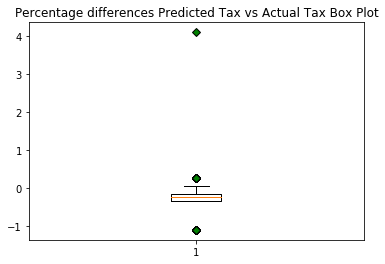

In [69]:
green_diamond = dict(markerfacecolor='g', marker='D')
data = df_in['% Diff']
fig1, ax1 = plt.subplots()
ax1.set_title('Percentage differences Predicted Tax vs Actual Tax Box Plot')
ax1.boxplot(data, flierprops=green_diamond)
plt.show()

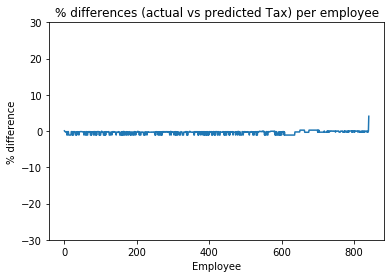

In [70]:
plt.title('% differences (actual vs predicted Tax) per employee')
plt.ylim(top=30,bottom=-30)
plt.ylabel('% difference')
plt.xlabel('Employee')
plt.plot(data) 
#run.log_image("Train set - Percentage diff per employee", plot=plt)
plt.show()

# Test Azure Table Storage

In [ ]:
from azure.cosmosdb.table.tableservice import TableService
from azure.cosmosdb.table.models import Entity
table_service = TableService(connection_string='DefaultEndpointsProtocol=https;AccountName=ngataxwithheld3648820366;AccountKey=VBBoKAoD/vsOijTn4YXheEGsfy70ZlE/jidC0mSlT3MJw1f6tx/bQLSCrcq9DrFAUbtLHvfj3RI9hTRDGb3Rjg==;EndpointSuffix=core.windows.net')

def get_cust(ml_service,sys,client,gcc,lcc,payroll_area):
    custs = table_service.query_entities('mlcust')
    for cust in custs:
        if  ( cust.ml_service == ml_service
        and cust.system == sys 
        and cust.client == client 
        and cust.gcc == gcc 
        and cust.lcc == lcc 
        and cust.payroll_area == payroll_area ):
            return cust
    return None

cust = get_cust('TWV','EQ1','402','ZCS','Z10','X1')
if cust is None:
    print('not found')
else:
    print('Model: ' + cust.model)